[117.31173618 136.68061765  81.81119069 145.50519918 132.38041457
  88.71136728 100.94178365  69.21109985  88.68464904 113.19354863]
MC price      = 8.060938
SE (MC)       = 0.131582
95% CI        = [7.803036, 8.318839]
N simulations = 10000
Black–Scholes = 8.021352
Absolute err  = 0.039586
Relative err  = 0.4935%


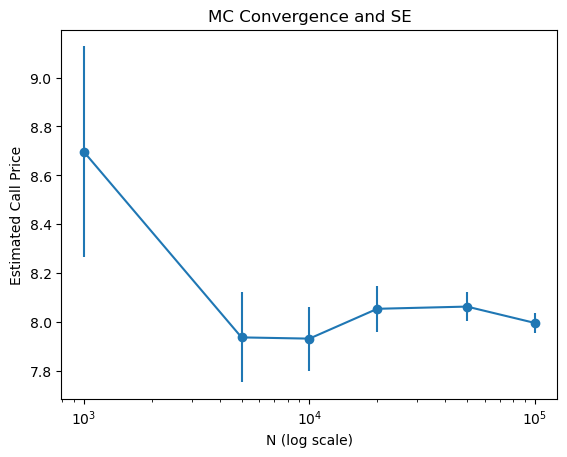

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 29 12:38:57 2025

@author: Jacon
"""
#Monte Carlo option pricing ST​=S0​⋅e^((r−0.5​σ^2)T+Zσ(t)^0.5)

import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

S0 = 100    # stock price today
K = 105     # strike price
T = 1.0     # time to maturity (1 year)
r = 0.05    # risk-free rate
sigma = 0.2 # volatility
n_sims = 10_000 # number of Monte Carlo simulations

# STEP 1: simulate stock price at maturity
Z = np.random.standard_normal(n_sims)  # random N(0,1)
ST = S0 * np.exp((r - 0.5 * sigma**2)*T + sigma*np.sqrt(T)*Z)

print(ST[:10])  # print first 10 simulated prices


payoffs = np.maximum(ST - K, 0.0)         # phi_i
N = len(payoffs)

# Monte Carlo estimator (discounted mean)
price_mc = math.exp(-r*T) * payoffs.mean()

# sample std of payoffs (ddof=1)
s_phi = payoffs.std(ddof=1)

# standard error of the estimator
se_mc = math.exp(-r*T) * s_phi / math.sqrt(N)

# 95% CI
z = 1.96
ci_lower = price_mc - z * se_mc
ci_upper = price_mc + z * se_mc

print(f"MC price      = {price_mc:.6f}")
print(f"SE (MC)       = {se_mc:.6f}")
print(f"95% CI        = [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"N simulations = {N}")

#Compare with BS

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

price_bs = black_scholes_call(S0, K, T, r, sigma)

abs_err = abs(price_mc - price_bs)
rel_err = abs_err / price_bs

print(f"Black–Scholes = {price_bs:.6f}")
print(f"Absolute err  = {abs_err:.6f}")
print(f"Relative err  = {rel_err:.4%}")

Ns = [1000, 5000, 10000, 20000, 50000, 100000]
estimates = []
ses = []

for n in Ns:
    Z = np.random.standard_normal(n)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoffs = np.maximum(ST - K, 0.0)
    est = np.exp(-r*T) * payoffs.mean()
    se = np.exp(-r*T) * payoffs.std(ddof=1) / (n**0.5)
    estimates.append(est)
    ses.append(se)

plt.errorbar(Ns, estimates, yerr=ses, fmt='o-')
plt.xscale('log')
plt.xlabel('N (log scale)')
plt.ylabel('Estimated Call Price')
plt.title('MC Convergence and SE')
plt.show()


Project 1 - Monte Carlo Option Pricing (annotated)

Goal of this project is to estimate the price of a European call option by Monte Carlo simulation. This notebook keeps the original code intact; explanations below show the mathematics and the Python mechanics for each block.

In [ ]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

- `numpy` (aliased `np`) for vectorised numerical operations and random draws.  
- `math` for scalar math functions (we use `math.exp` for a scalar discount factor).  
- `scipy.stats.norm` provides the normal CDF used in the Black–Scholes formula.  
- `matplotlib.pyplot` for plotting results.
 


In [ ]:
S0 = 100    # stock price today
K = 105     # strike price
T = 1.0     # time to maturity (1 year)
r = 0.05    # risk-free rate
sigma = 0.2 # volatility
n_sims = 10_000 # number of Monte Carlo simulations

Increasing `n_sims` reduces the standard error and narrows the confidence interval, improving accuracy — but at the cost of higher computational effort. 
- **Law of Large Numbers (LLN):** ensures that as the number of simulations \(N\) grows, the sample mean of simulated payoffs converges to the true expected payoff.  
$$
\frac{1}{N} \sum_{i=1}^N \phi_i \;\;\xrightarrow[]{N \to \infty}\;\; \mathbb{E}[\phi]
$$

- **Central Limit Theorem (CLT):** guarantees that the distribution of the Monte Carlo estimator is approximately normal for large \(N\), with variance shrinking at a rate of \(1/N\). This justifies using confidence intervals.  
$$
\hat{C}_{MC} \sim \mathcal{N}\left(C, \frac{\sigma^2}{N}\right)
$$

In [ ]:
# STEP 1: simulate stock price at maturity
Z = np.random.standard_normal(n_sims)  # random N(0,1)
ST = S0 * np.exp((r - 0.5 * sigma**2)*T + sigma*np.sqrt(T)*Z)

print(ST[:10])  # print first 10 simulated prices

### Simulating $S_T$ (Geometric Brownian Motion)
**Mathematics:** under Black–Scholes assumptions the terminal stock price is
$$
S_T = S_0 \exp\Big((r - \tfrac{1}{2}\sigma^2)T + \sigma \sqrt{T}\,Z\Big),
\qquad Z\sim N(0,1).
$$
- The term $(r - \tfrac{1}{2}\sigma^2)T$ is the risk-neutral drift.
- The term $\sigma\sqrt{T}Z$ introduces randomness from Brownian motion.

**Python mechanics:**
- `Z = np.random.standard_normal(n_sims)` produces an array of `n_sims` independent standard normals (shape `(n_sims,)`).
- `np.exp(...)` is vectorised: it applies the exponential to each element of the array expression, returning an array of simulated prices `ST`.
- `ST` therefore is a NumPy array of length `n_sims`. `print(ST[:10])` shows the first 10 simulated terminal prices as a sanity check.

In [ ]:
payoffs = np.maximum(ST - K, 0.0)         # phi_i
N = len(payoffs)

### Option payoff at maturity

**Mathematics:** for a European call, payoff $\phi(S_T)=\max(S_T-K,0)$.

**Python mechanics:**
- `np.maximum(ST - K, 0.0)` computes the payoff elementwise for the whole vector `ST` (fast, no loop).
- `payoffs` is a 1-D array of the simulated payoffs.
- `N = len(payoffs)` is the number of simulated payoffs (should equal `n_sims`).

In [ ]:
# Monte Carlo estimator (discounted mean)
price_mc = math.exp(-r*T) * payoffs.mean()

# sample std of payoffs (ddof=1)
s_phi = payoffs.std(ddof=1)

# standard error of the estimator
se_mc = math.exp(-r*T) * s_phi / math.sqrt(N)

# 95% CI
z = 1.96
ci_lower = price_mc - z * se_mc
ci_upper = price_mc + z * se_mc

print(f"MC price      = {price_mc:.6f}")
print(f"SE (MC)       = {se_mc:.6f}")
print(f"95% CI        = [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"N simulations = {N}")

### Monte Carlo estimator, standard error and confidence interval

**Estimator (math):**
$$
\hat{C} = e^{-rT}\,\frac{1}{N}\sum_{i=1}^N \phi(S_T^{(i)})
$$
This is the discounted sample mean of payoffs.

**Standard error (math):**
Let $s_\phi$ be the sample standard deviation of payoffs. The standard error of $\hat C$ tells you how much the Monte Carlo price would vary across independent runs; narrower SE = more precise estimate.
$$
\text{SE}(\hat C) = e^{-rT}\,\frac{s_\phi}{\sqrt{N}}.
$$

**Why `ddof=1`?** `payoffs.std(ddof=1)` uses \(N-1\) in the variance denominator (sample standard deviation), which is the unbiased estimator for population variance. We use that value to form the standard error.

**95% CI:** under CLT (large N) the MC estimator is approximately normal, so a 95% CI is $\hat C \pm 1.96\cdot \text{SE}$.



In [ ]:
#Compare with BS

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

price_bs = black_scholes_call(S0, K, T, r, sigma)

abs_err = abs(price_mc - price_bs)
rel_err = abs_err / price_bs

print(f"Black–Scholes = {price_bs:.6f}")
print(f"Absolute err  = {abs_err:.6f}")
print(f"Relative err  = {rel_err:.4%}")

### Black–Scholes closed-form price

**Mathematics:** for a European call,
$$
C_{\text{BS}} = S_0 \Phi(d_1) - K e^{-rT}\Phi(d_2),
$$
where
$$
d_1 = \frac{\ln(S_0/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}},\qquad
d_2 = d_1 - \sigma\sqrt{T},
$$
and $\Phi(\cdot)$ is the standard normal CDF.

**Python mechanics:**
- `norm.cdf(d1)` computes $\Phi(d_1)$.
- We compute `price_bs` and then absolute / relative errors vs Monte Carlo to check the simulation’s accuracy.


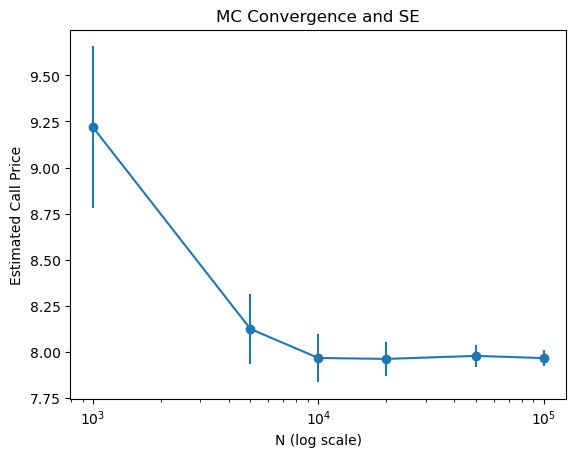

In [2]:
Ns = [1000, 5000, 10000, 20000, 50000, 100000]
estimates = []
ses = []

for n in Ns:
    Z = np.random.standard_normal(n)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoffs = np.maximum(ST - K, 0.0)
    est = np.exp(-r*T) * payoffs.mean()
    se = np.exp(-r*T) * payoffs.std(ddof=1) / (n**0.5)
    estimates.append(est)
    ses.append(se)

plt.errorbar(Ns, estimates, yerr=ses, fmt='o-')
plt.xscale('log')
plt.xlabel('N (log scale)')
plt.ylabel('Estimated Call Price')
plt.title('MC Convergence and SE')
plt.show()

### Convergence experiment and error bars

**Purpose:** show how the Monte Carlo estimate converges as `N` increases and how the standard error shrinks.

**What the code does:**
- For each `n` in `Ns` we run an independent Monte Carlo experiment, compute the discounted mean estimate and its SE.
- `plt.errorbar` plots each estimate with a vertical bar equal to ±1 SE.
- `plt.xscale('log')` makes the x-axis logarithmic so you can see the $1/\sqrt{N}$ behaviour clearly.

**Expected behaviour:** the cloud of estimates converges to the Black–Scholes price as `N` increases; SE should shrink approximately proportional to $1/\sqrt{N}$.
